### **Computer Vision Project 1 - Ashok Shanmuga Sundaram** 

## **PART-1 - Objective:**
The given dataset comprises of images from 12 plant species. The objective is to create a classifier capable of determining a plant's species from a photo

### **1.0 Importing the Libraries**

In [107]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.1'

In [108]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [109]:
import numpy as np
import pandas as pd
from glob import glob
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
import time

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Sequential, model_from_json, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense ,Input
from keras.optimizers import Adam ,RMSprop


### **1.1. EDA and Visualization**

*   Importing Data
*   Analysing the dimensions of data
*   Visualizing the data







In [110]:
from google.colab import drive

In [111]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [112]:
# Adding path to the folder where dataset files are
project_path = '/content/drive/My Drive/AIML/Projects/CV1/'

In [ ]:
train_data_path= project_path + 'Plant Seedling Classification Data/train'

images = []
classes=[]
for class_folder_name in os.listdir(train_data_path):
    class_folder_path = os.path.join(train_data_path, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images.append(image_bgr)
        classes.append(class_label)

In [ ]:
print('Total Number of images :',len(images))
print('The shape of a sample image :',images[0].shape)

Total Number of images : 4767
The shape of a sample image : (281, 281, 3)


Text(0.5, 0.98, 'Class Distribution of the dataset')

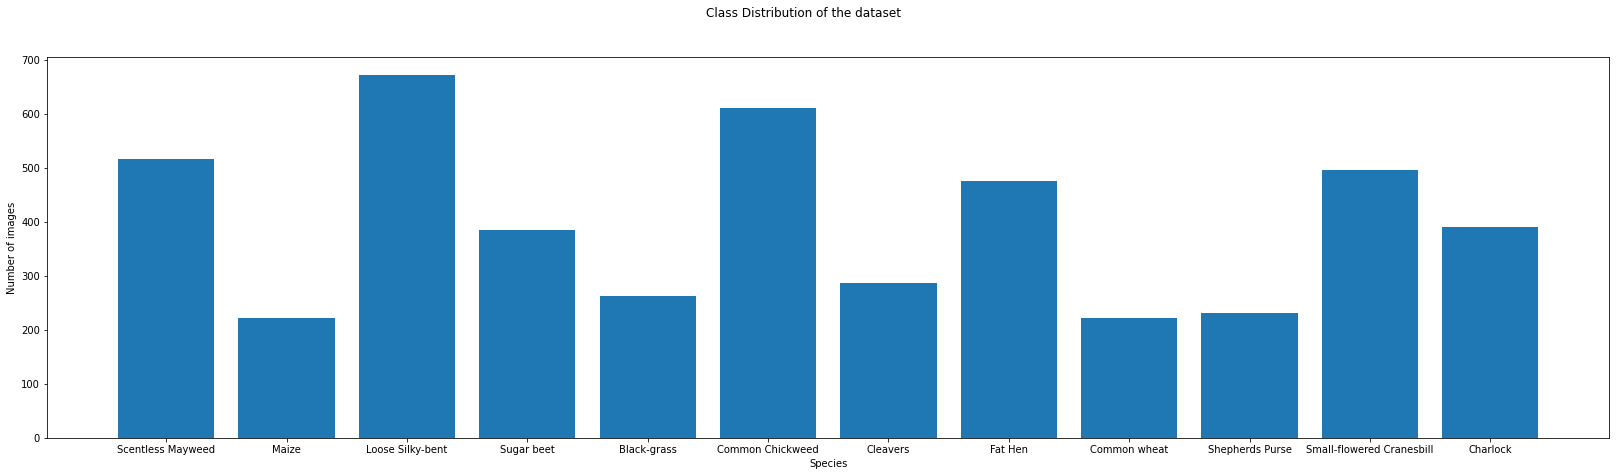

In [ ]:
images = np.array(images)
classes = np.array(classes)
values =[]
labels=[]
for label in set(classes):
    values.append(len(images[classes == label]))
    labels.append(label)

fig, ax = plt.subplots(figsize=(28,7))
ax.bar(labels, values)
ax.set_xlabel("Species")
ax.set_ylabel("Number of images")
fig.suptitle('Class Distribution of the dataset')

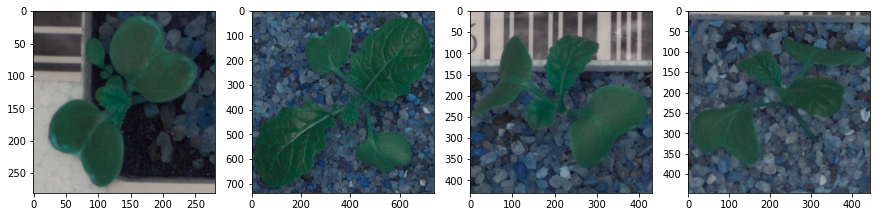

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15,15))
axs[0].imshow(images[0])
axs[1].imshow(images[20])
axs[2].imshow(images[30])
axs[3].imshow(images[80])

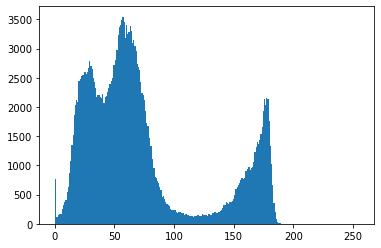

In [ ]:
plt.hist(images[0].ravel(),256,[0,255])
plt.show()

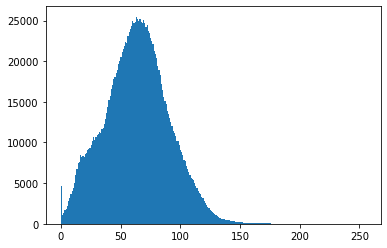

In [ ]:
plt.hist(images[20].ravel(),256,[0,255])
plt.show()

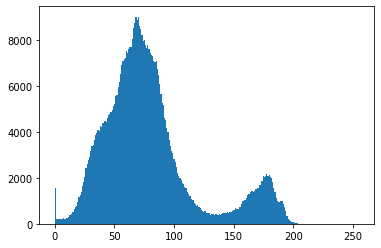

In [ ]:
plt.hist(images[30].ravel(),256,[0,255])
plt.show()

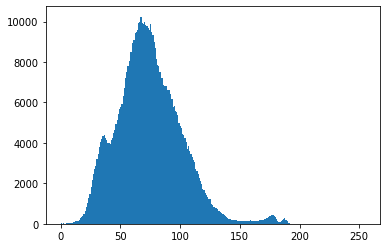

In [ ]:
plt.hist(images[80].ravel(),256,[0,255])
plt.show()

**Inference from Histograms and Sample Images:**
*   The intensities of the images are highly skewed towards left. The images are darker
*   Values of intensities of images lie between the range 0-200

**Preprocessing data and arriving at Train/Validation split**

In [ ]:
def load_dataset(path):
    data=load_files(path)
    plant_files=np.array(data['filenames'])
    plant_targets=np_utils.to_categorical(np.array(data['target']),12)
    return plant_files,plant_targets

print('Loading Train Files and Targets')
train_files, train_targets = load_dataset(train_data_path)
print('Loading Complete!')
print('There are %d training plant images.' % len(train_files))

Loading Train Files and Targets
Loading Complete!
There are 4767 training plant images.


In [ ]:
#list of plant names
plant_names= [item[83:-1] for item in sorted(glob(train_data_path + "/*/"))]
print('There are %d total plant categories.' % len(plant_names))

There are 12 total plant categories.


In [ ]:
plant_names

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [ ]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(256, 256))
    # convert PIL.Image.Image type to 3D tensor with shape (256, 256, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 256, 256, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255

100%|██████████| 4767/4767 [01:21<00:00, 58.24it/s]


In [ ]:
train_tensors.shape

(4767, 256, 256, 3)

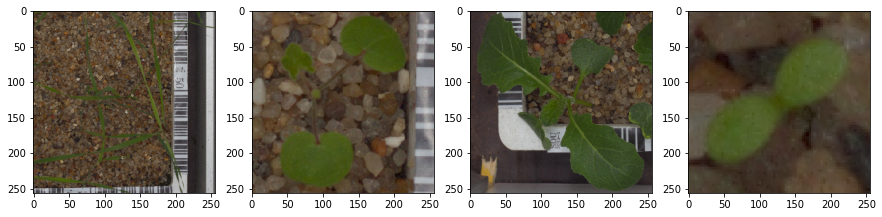

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15,15))

axs[0].imshow(train_tensors[0])
axs[1].imshow(train_tensors[20])
axs[2].imshow(train_tensors[30])
axs[3].imshow(train_tensors[80])

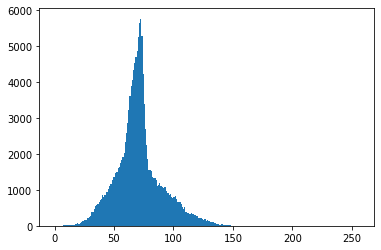

In [ ]:
img = cv2.imread(train_data_path + "/Maize/ff4b55219.png",0)
plt.hist(img.ravel(),256,[0,256]) 
plt.show()



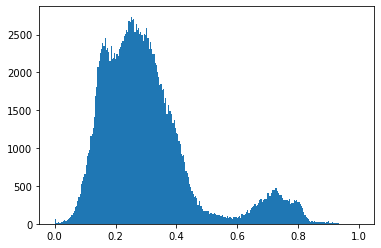

In [ ]:
plt.hist(train_tensors[0].ravel(),256,[0,1])
plt.show()

In [ ]:
seed = 20
np.random.seed(seed)

# Split the train and the validation set
train_tensors, val_train, train_targets, val_targets = train_test_split(train_tensors,
                                              train_targets, 
                                              test_size=0.15,
                                              random_state=seed
                                             )

print(train_tensors.shape)
print(val_train.shape)
print(train_targets.shape)
print(val_targets.shape)

(4051, 256, 256, 3)
(716, 256, 256, 3)
(4051, 12)
(716, 12)


**1.2.a. Training Image Classifier Model using Neural Network**

In [ ]:
#Reshape data to 1D
X = np.asarray(train_tensors).reshape(4051,196608)
##Initialize the Artificial Neural Network Classifier
model = Sequential()

# Input Layer
#Adding Input layer and activation functions ReLU
model.add(Dense(512, kernel_initializer='he_normal', activation ='relu',input_shape = (196608,)))

#Hidden Layer 1
#Adding first Hidden layer
model.add(Dense(256, kernel_initializer='he_normal', activation ='relu'))

#Hidden Layer 2
#Adding second Hidden layer
model.add(Dense(128, kernel_initializer='he_normal', activation ='relu'))

#Hidden Layer 3
#Adding third Hidden layer
model.add(Dense(64, kernel_initializer='he_normal', activation ='relu'))

#Hidden Layer 4
#Adding fourth Hidden layer
model.add(Dense(32, kernel_initializer='he_normal', activation ='relu'))

# Output Layer
#Adding output layer which is of 12 nodes (digits)
model.add(Dense(12,activation ='softmax' ))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               100663808 
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 12)                396       
Total params: 100,838,764
Trainable params: 100,838,764
Non-trainable params: 0
________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X, train_targets, batch_size=128, epochs=40, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/40
29/29 [==============================] - 39s 1s/step - loss: 2.4403 - accuracy: 0.1377 - val_loss: 2.4340 - val_accuracy: 0.1576
Epoch 2/40
29/29 [==============================] - 35s 1s/step - loss: 2.4385 - accuracy: 0.1377 - val_loss: 2.4320 - val_accuracy: 0.1576
Epoch 3/40
29/29 [==============================] - 35s 1s/step - loss: 2.4367 - accuracy: 0.1377 - val_loss: 2.4301 - val_accuracy: 0.1576
Epoch 4/40
29/29 [==============================] - 35s 1s/step - loss: 2.4351 - accuracy: 0.1377 - val_loss: 2.4284 - val_accuracy: 0.1576
Epoch 5/40
29/29 [==============================] - 35s 1s/step - loss: 2.4336 - accuracy: 0.1377 - val_loss: 2.4266 - val_accuracy: 0.1576
Epoch 6/40
29/29 [==============================] - 35s 1s/step - loss: 2.4322 - accuracy: 0.1377 - val_loss: 2.4251 - val_accuracy: 0.1576
Epoch 7/40
29/29 [==============================] - 35s 1s/step - loss: 2.4309 - accuracy: 0.1377 - val_loss: 2.4236 - val_accuracy: 0.1576
Epoch 8/40
29/29 [==

**1.2.b. Training Image Classifier Model using CNN**

In [ ]:
model= Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))


model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(GlobalAveragePooling2D())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(12,activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      12832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0

In [ ]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
checkpointer = ModelCheckpoint(filepath= project_path + 'saved_models/cnn_model_wo_aug_af.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, epochs = 20, validation_data = (val_train,val_targets),callbacks=[checkpointer],batch_size = 128)

Epoch 1/20
32/32 [==============================] - 975s 30s/step - loss: 2.4842 - accuracy: 0.1182 - val_loss: 2.4121 - val_accuracy: 0.1466

Epoch 00001: val_loss improved from inf to 2.41206, saving model to /content/drive/My Drive/AIML/Projects/CV1/saved_models/cnn_model_wo_aug_af.hdf5
Epoch 2/20
32/32 [==============================] - 973s 30s/step - loss: 2.4204 - accuracy: 0.1400 - val_loss: 2.4098 - val_accuracy: 0.1466

Epoch 00002: val_loss improved from 2.41206 to 2.40977, saving model to /content/drive/My Drive/AIML/Projects/CV1/saved_models/cnn_model_wo_aug_af.hdf5
Epoch 3/20
32/32 [==============================] - 979s 31s/step - loss: 2.4335 - accuracy: 0.1419 - val_loss: 2.4121 - val_accuracy: 0.1466

Epoch 00003: val_loss did not improve from 2.40977
Epoch 4/20
32/32 [==============================] - 983s 31s/step - loss: 2.3654 - accuracy: 0.1860 - val_loss: 2.0356 - val_accuracy: 0.2947

Epoch 00004: val_loss improved from 2.40977 to 2.03565, saving model to /cont

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_tensors)

In [ ]:
batch = 32
checkpointer = ModelCheckpoint(filepath=project_path+'saved_models/cnn_model_with_aug_af.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit_generator(datagen.flow(train_tensors,train_targets,batch_size=batch),epochs = 10, validation_data = (val_train,val_targets),
                              verbose = 1, steps_per_epoch=train_tensors.shape[0] // batch
                              , callbacks=[learning_rate_reduction, checkpointer])

Epoch 1/10
126/126 [==============================] - 1024s 8s/step - loss: 1.3998 - accuracy: 0.5123 - val_loss: 1.1684 - val_accuracy: 0.5810

Epoch 00001: val_loss improved from inf to 1.16839, saving model to /content/drive/My Drive/AIML/Projects/CV1/saved_models/cnn_model_with_aug_af.hdf5
Epoch 2/10
126/126 [==============================] - 1017s 8s/step - loss: 1.3044 - accuracy: 0.5457 - val_loss: 1.0461 - val_accuracy: 0.6564

Epoch 00002: val_loss improved from 1.16839 to 1.04610, saving model to /content/drive/My Drive/AIML/Projects/CV1/saved_models/cnn_model_with_aug_af.hdf5
Epoch 3/10
126/126 [==============================] - 1019s 8s/step - loss: 1.2376 - accuracy: 0.5800 - val_loss: 1.0394 - val_accuracy: 0.6425

Epoch 00003: val_loss improved from 1.04610 to 1.03938, saving model to /content/drive/My Drive/AIML/Projects/CV1/saved_models/cnn_model_with_aug_af.hdf5
Epoch 4/10
126/126 [==============================] - 1015s 8s/step - loss: 1.1373 - accuracy: 0.6079 - val

In [ ]:
model.load_weights(project_path+'saved_models/cnn_model_with_aug_af.hdf5')
accuracy=model.evaluate(x=val_train,y=val_targets,batch_size=32)
print("Loss of the model: {} , Accuracy of Model :{} ".format(accuracy[0],accuracy[1]))

23/23 [==============================] - 40s 2s/step - loss: 0.6420 - accuracy: 0.7765
Loss of the model: 0.6419996619224548 , Accuracy of Model :0.7765362858772278 


In [ ]:
def one_hot_to_dense(labels_one_hot):
    num_labels = labels_one_hot.shape[0]
    num_classes = labels_one_hot.shape[1]
    labels_dense = np.where(labels_one_hot == 1)[1]      
    return labels_dense

In [ ]:
validation_predictions = model.predict_classes(val_train)
report=classification_report(one_hot_to_dense(val_targets),validation_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.33      0.21      0.26        42
           1       0.67      0.90      0.76        58
           2       0.75      0.66      0.70        41
           3       0.99      0.86      0.92       103
           4       0.95      0.51      0.67        35
           5       0.91      0.84      0.87        73
           6       0.70      0.90      0.79       105
           7       0.79      0.93      0.86        29
           8       0.93      0.74      0.82        72
           9       0.48      0.57      0.52        35
          10       0.72      0.97      0.83        65
          11       0.96      0.74      0.83        58

    accuracy                           0.78       716
   macro avg       0.76      0.74      0.74       716
weighted avg       0.79      0.78      0.77       716



In [ ]:
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
           'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_species = len(species)
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': species, 'abbreviation': abbreviation})

class abbreviation
0                 Black-grass           BG
1                    Charlock           Ch
2                    Cleavers           Cl
3            Common Chickweed           CC
4                Common wheat           CW
5                     Fat Hen           FH
6            Loose Silky-bent          LSB
7                       Maize            M
8           Scentless Mayweed           SM
9             Shepherds Purse           SP
10  Small-flowered Cranesbill          SFC
11                 Sugar beet           SB

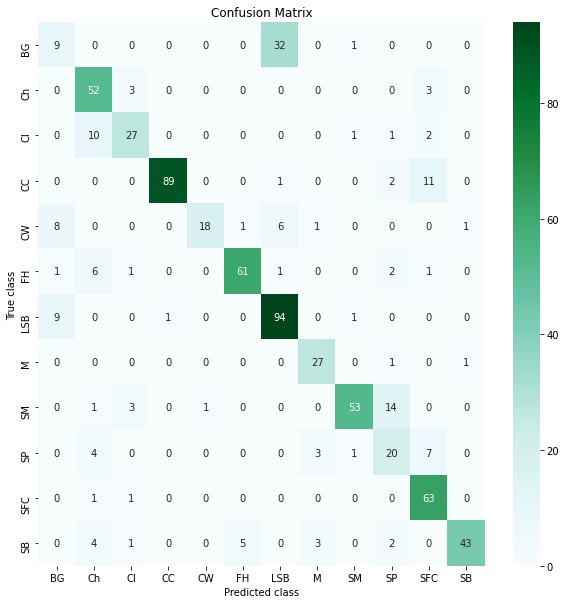

In [ ]:
conf_mat= confusion_matrix(one_hot_to_dense(val_targets), validation_predictions)
fig, ax = plt.subplots(1,figsize=(10,10))

ax = sns.heatmap(conf_mat, ax=ax, cmap=plt.cm.BuGn, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

### **1.3.Comparison of Results obtained by Image classifier models and Observations**

AIML Image classifier has been trained by using Neural Networks and CNN models separately. The accuracy did not improve beyond a point though number of epochs were increased for neural network model. The accuracy of CNN model is far better than Neural Network model.The accuracy of CNN model got further increased when data augmentation techiques are used for image processing.CNN model is chosen as best performing model and used for predicting the class of given Image

## **1.4 and 1.5 - Saving and Loading best performing model and Predicting the class of image**
Steps:
1.  Saving the best performing model - CNN model to Json file
2.  Loading the json file
3.  Import the the given image in the “ Prediction” folder to predict the class
4.  Using best trained image classifier model - CNN model - to predict the class


In [ ]:
model_json = model.to_json()
with open(project_path+"saved_models/model_after_rev.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(project_path+"saved_models/model_after_rev.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
def plant_seed_classification(image):
    
    image = path_to_tensor(image).astype('float32')/255
    
    json_file = open(project_path+'saved_models/model_after_rev.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(project_path+"saved_models/model_after_rev.h5")
    print("Loaded model from disk")
    
    prediction = model.predict_classes(image)
    
    print('The predicted Class of the image is {}'.format(prediction))
    INV_CLASS = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'
     }
    print('The class of the plant is',[INV_CLASS[p] for p in prediction])

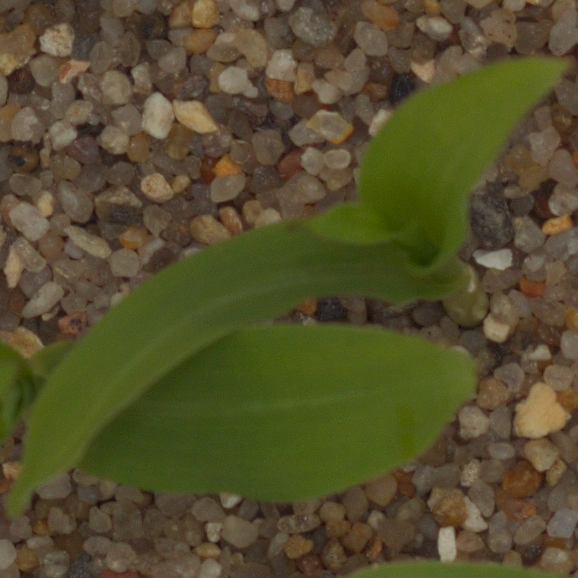

Loaded model from disk
The predicted Class of the image is [7]
The class of the plant is ['Maize']


In [ ]:
from google.colab.patches import cv2_imshow
pred_image = cv2.imread(project_path + '/Prediction/Predict.png')
cv2_imshow(pred_image)
plant_seed_classification(project_path + '/Prediction/Predict.png')

**Predictions Results:**
The given image for Prediction is processed by Plant Seedling Image classifier model and predicted as "Maize"

##**PART- 2 - Image Classification - Comparison of performance between CNN, NN and Supervised Learning models**

**Supervised Learning Models:** Supervised  learning is a machine  learning technique which is  we can associate between inputs and ground truth in a  dataset. Supervised Learning models works well for classification and regression problems. However,  for image  classification, Neural Networks provides better accuracy than using Supervised Learning models like modified Support Vector Machines (SVM) with feature extraction using PCA  or  K-Nearest  Neighbors (KNN)

**Neural Networks :** A simple neural network (NN) uses dense layers. Hence, it is better than Supervised learning models for Image classification. Though the accuracy of model will be better than Supervised learning models. However, it may not be very good. Performance of NN can be improved by Adding more layers, Experimenting with different optimizer function/regularization function,Increasing number of epochs, Increasing amount of data

**Convolutional Neural Networks:** Convolution layers have proved to be very good  in image classification. They allow parameter sharing which results in a very optimized network compared to using Dense layers. The network training time will be lesser and training loss is very optimized than simple neural networks. Transfer Learning can also be used.Transfer learning is a method of reusing the already acquired knowledge. The idea is to use a state of the art model which is already trained on a larger dataset for long time and proven to work well in related task. 

## **PART- 3 -Building Car Image Classifier Data**


*   Building  car image classifier data - Challenges
*   Import and display the images in python against car labels 





**Building Car Image Classifier Dataset - Challenges:**
1. Pictures of cars taken by team can be stored in file location in an PC. This is the raw dataset. Dimensions of pictures, picture clarity may not be uniform across dataset
2. Detecting all the objects on the image of the raw dataset is another challenge
3. Devising and applying rules based on the objects detected in the picture to select the right images
4. There should be only one vehicle (car) in the image
5. the confidence index of the detection of the car should be higher (more than 95%)
6. resizing the pictures and identifying correct labels for the classification. Finally, csv file can be created with the columns "Car Image" and "Car Make"






**Import and display car images in python :**

In [ ]:
img_data_path= project_path + ('/Cars Images/')

def load_dataset(path):
    data=load_files(path)
    car_files=np.array(data['filenames'])
    car_targets=np_utils.to_categorical(np.array(data['target']),15)
    return car_files, car_targets

print('Loading car Files and Targets')
car_files, car_targets = load_dataset(img_data_path)
print('Loading Complete!')
print('There are %d car images.' % len(car_files))

#list of car names
carfile_names= [item[60:] for item in sorted(glob(img_data_path + "cars/*.jpg"))]
print('There are %d car file names.' % len(carfile_names))
print(carfile_names)

Loading car Files and Targets
Loading Complete!
There are 15 car images.
There are 15 car file names.
['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg']


In [ ]:
def carpath_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(256, 256))
    # convert PIL.Image.Image type to 3D tensor with shape (256, 256, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 256, 256, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def carpaths_to_tensor(img_paths):
    list_of_tensors = [carpath_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
# pre-process the data for Keras
car_tensors = carpaths_to_tensor(car_files).astype('float32')/255

100%|██████████| 15/15 [00:00<00:00, 76.83it/s]


In [ ]:
car_tensors.shape


(15, 256, 256, 3)

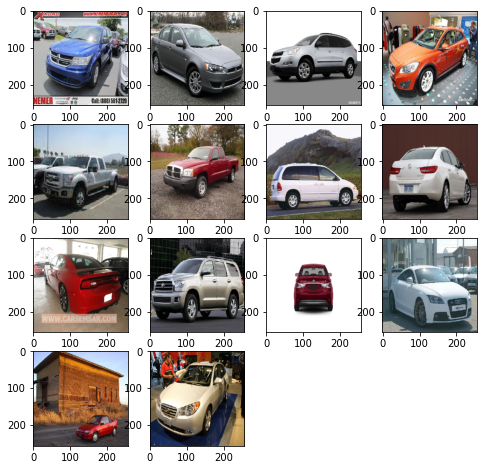

In [ ]:
fig=plt.figure(figsize=(8,8))

for i in range(1, len(carfile_names)):
    img=car_tensors[i]
    fig.add_subplot(4,4,i)
    plt.imshow(img,cmap='gray')
plt.show()



Car images collected and stored in car dataset are displayed as above

## **PART- 4**
Objective is to create flower classifier capable of determining a flower’s species from a photo

**4.1. EDA and Visualization**

Importing Data

Analysing the dimensions of data

Preprocessing Data

Visualizing the data - Displaying images, labels, images vs labels, applying different filters

In [ ]:
!pip install tflearn
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

     |████████████████████████████████| 112kB 6.6MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp36-none-any.whl size=127301 sha256=d49fd45f45f13d912e8ff7ade3e801f130dca51063fcf1ce9378090a397b0fd0
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [ ]:
# Importing oxflower17 dataset
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data (one_hot=True)

Instructions for updating:
non-resource variables are not supported in the long term


100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


In [ ]:
# Printing the shape and data type of extracted data
print("X data-- Shape :", X.shape,"and Data Type : ", X.dtype)
print("Y data-- Shape :", Y.shape,"and Data Type : ", Y.dtype)

X data-- Shape : (1360, 224, 224, 3) and Data Type :  float32
Y data-- Shape : (1360, 17) and Data Type :  float64


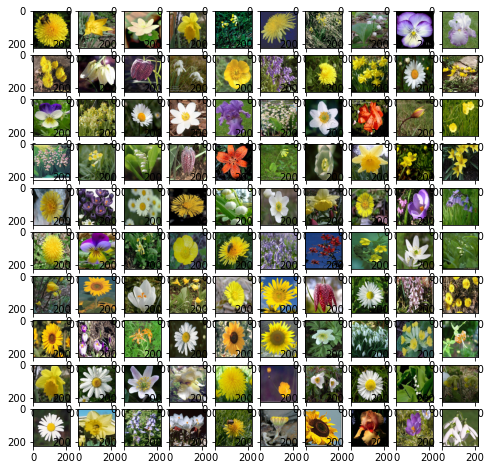

In [ ]:
# Visualizing the dataset
fig=plt.figure(figsize=(8,8))
columns=10
rows=10
for i in range(1, columns*rows+1):
    img=X[i]
    fig.add_subplot(rows,columns,i)
    plt.imshow(img,cmap='gray')
plt.show()

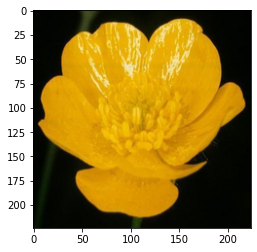

One hot encoded value:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# show an image and label in the dataset
plt.imshow(X[0],cmap='gray')    
plt.show()
print('One hot encoded value: ', Y[0])

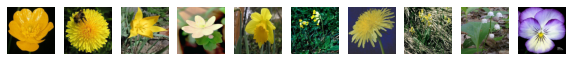

One hot encoded values for each of the above image: 
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
# visualizing the first 10 images in the dataset and their one hot encoded values
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X[i],cmap='gray')
    plt.axis('off')
plt.show()
print('One hot encoded values for each of the above image: \n %s' % (Y[0:10]))

In [ ]:
train_data_path1= project_path + 'Flowers-Classification/17flowers-train/jpg/'
images = []
classes=[]
for class_folder_name in os.listdir(train_data_path1):
    class_folder_path = os.path.join(train_data_path1, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images.append(image_bgr)
        classes.append(class_label)

labels: ['7', '5', '10', '15', '14', '9', '12', '1', '16', '3', '6', '11', '4', '8', '0', '13', '2']


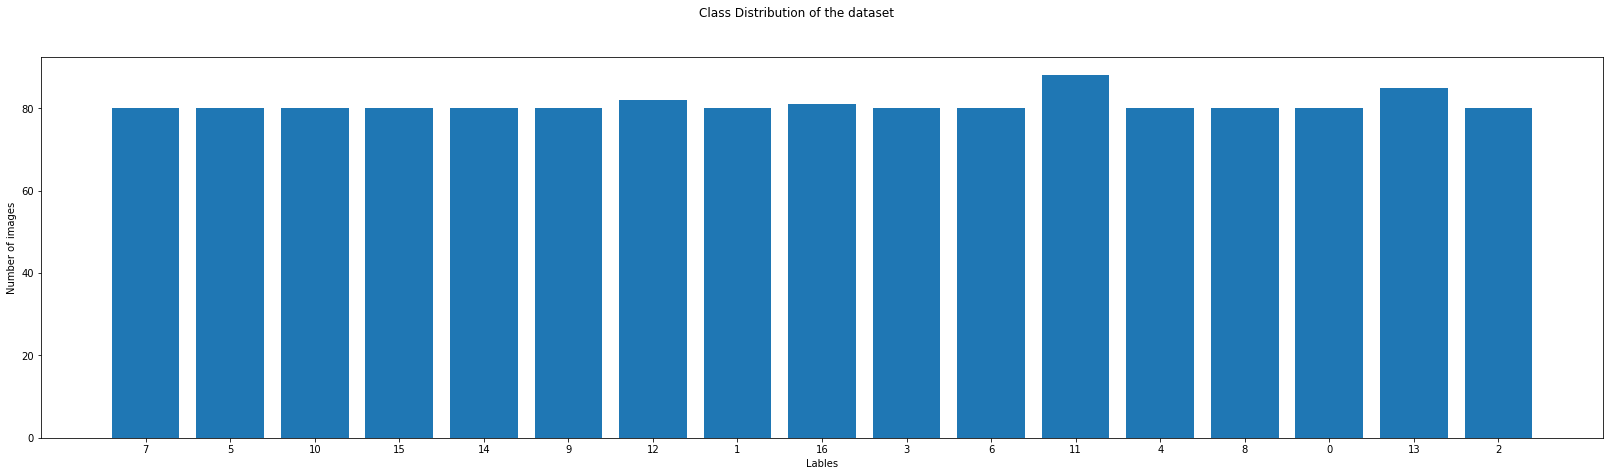

In [ ]:
images = np.array(images)
classes = np.array(classes)
values =[]
labels=[]
for label in set(classes):
    values.append(len(images[classes == label]))
    labels.append(label)

fig, ax = plt.subplots(figsize=(28,7))
ax.bar(labels, values)
ax.set_xlabel("Lables")
ax.set_ylabel("Number of images")
fig.suptitle('Class Distribution of the dataset')
print("labels:",labels)

Blurred Image:


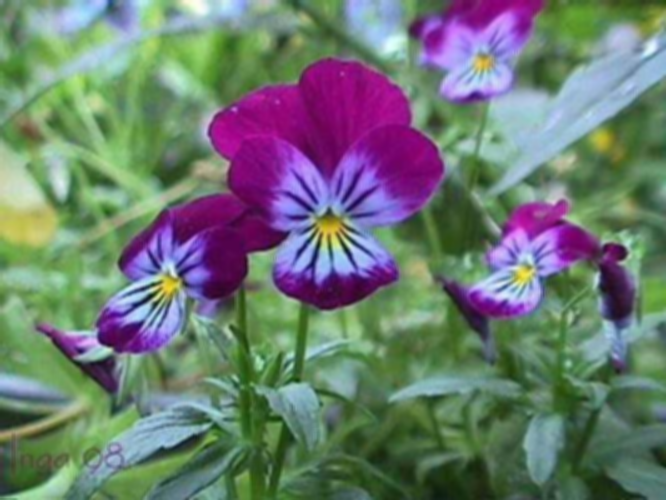

Sharpened Image:


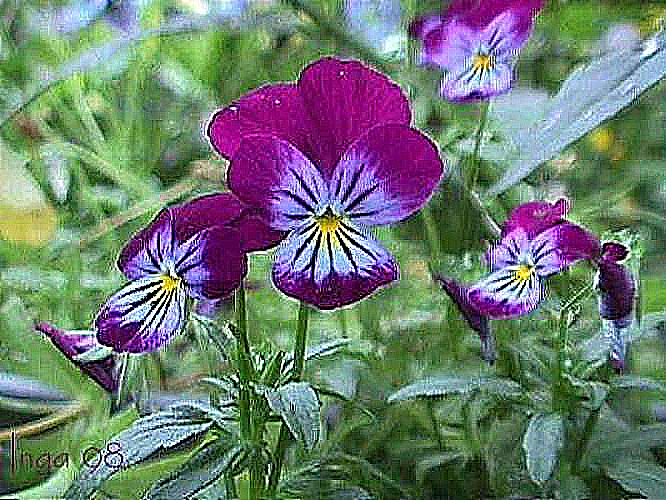

Embossed Image:


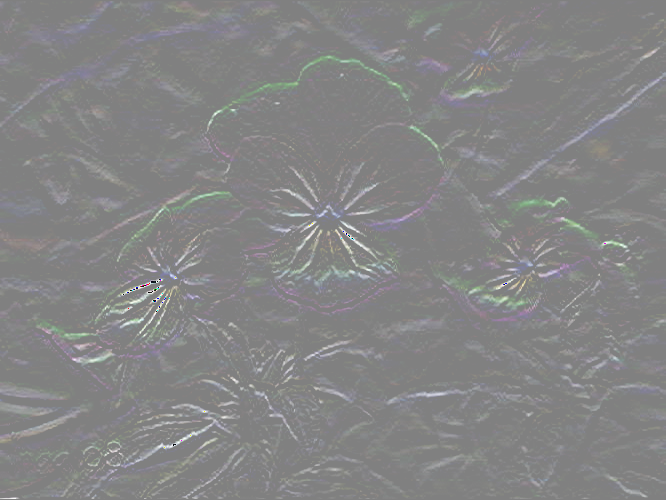

Image - Edge Detection:


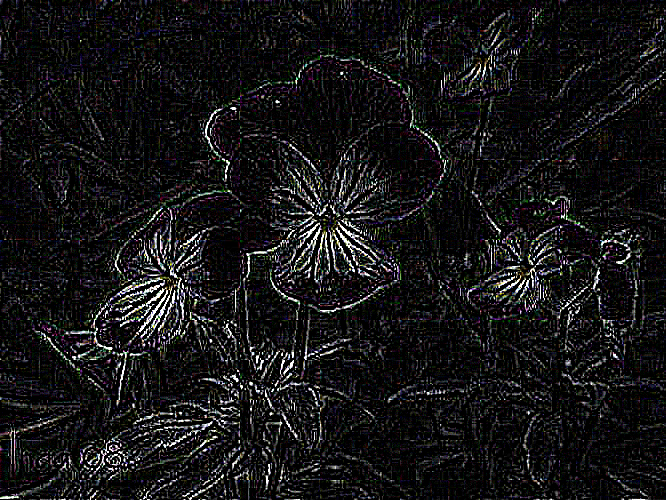

In [ ]:
# Applying Image filters 
# Blur image
from google.colab.patches import cv2_imshow
image = cv2.imread(train_data_path1+'16/image_1359.jpg')
blur_image = cv2.blur(image,(4,4))
print("Blurred Image:")
cv2_imshow(blur_image)

# Sharpening image
filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
Sharpened_image = cv2.filter2D(image,-1,filter)
print("Sharpened Image:")
cv2_imshow(Sharpened_image)

# Embossing Image
filter = np.array([[0,1,0],[0,0,0],[0,-1,0]])
emboss_img=cv2.filter2D(image,-1,filter)
emboss_img=emboss_img+128
print("Embossed Image:")
cv2_imshow(emboss_img)

# Edge Detection
filter = np.array([[0,0,-1,0,0],[0,-1,-2,-1,0],[-1,-2,16,-2,-1],[0,-1,-2,-1,0],[0,0,-1,0,0]])
edge_detect_img=cv2.filter2D(image,-1,filter)
print("Image - Edge Detection:")
cv2_imshow(edge_detect_img)

**4.2.a - Train tuning AIML image classifier model using CNN model and Testing**

In [ ]:
model= Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))


model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(GlobalAveragePooling2D())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(17,activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 16)      1216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 32)      12832     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 56, 56, 32)       

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X, Y, batch_size=64, epochs=20, verbose=1, validation_split=0.1, shuffle=True)

Train on 1224 samples, validate on 136 samples
Epoch 1/20
1224/1224 [==============================] - 228s 186ms/sample - loss: 2.8239 - acc: 0.0556 - val_loss: 2.8279 - val_acc: 0.0882
Epoch 2/20
1224/1224 [==============================] - 219s 179ms/sample - loss: 2.7417 - acc: 0.0850 - val_loss: 2.5148 - val_acc: 0.0515
Epoch 3/20
1224/1224 [==============================] - 218s 178ms/sample - loss: 2.5669 - acc: 0.1275 - val_loss: 2.4393 - val_acc: 0.1103
Epoch 4/20
1224/1224 [==============================] - 226s 184ms/sample - loss: 2.4107 - acc: 0.1511 - val_loss: 2.3806 - val_acc: 0.1471
Epoch 5/20
1224/1224 [==============================] - 217s 177ms/sample - loss: 2.3521 - acc: 0.1871 - val_loss: 2.2809 - val_acc: 0.1618
Epoch 6/20
1224/1224 [==============================] - 217s 178ms/sample - loss: 2.2799 - acc: 0.2279 - val_loss: 2.2199 - val_acc: 0.2500
Epoch 7/20
1224/1224 [==============================] - 216s 176ms/sample - loss: 2.1747 - acc: 0.2296 - val_loss

In [ ]:
# Printing loss and accuracy for test data
results = model.evaluate(X, Y)
print('Test_acc using CNN model : ', results[1])

print(model.metrics_names)
print(results)

Test_acc using CNN model :  0.56691176
['loss', 'acc']
[1.2295289867064532, 0.56691176]


**4.2.b - Train tune AIML image classifier model using Neural Networks and Testing**

In [ ]:
#Reshape data to 1D
X_NN = np.asarray(X).reshape(1360,150528)
##Initialize the Artificial Neural Network Classifier
model = Sequential()

# Input Layer
#Adding Input layer and activation functions ReLU
model.add(Dense(512, kernel_initializer='he_normal', activation ='relu',input_shape = (150528,)))

#Hidden Layer 1
#Adding first Hidden layer
model.add(Dense(256, kernel_initializer='he_normal', activation ='relu'))

#Hidden Layer 2
#Adding second Hidden layer
model.add(Dense(128, kernel_initializer='he_normal', activation ='relu'))

#Hidden Layer 3
#Adding third Hidden layer
model.add(Dense(64, kernel_initializer='he_normal', activation ='relu'))

#Hidden Layer 4
#Adding fourth Hidden layer
model.add(Dense(32, kernel_initializer='he_normal', activation ='relu'))

# Output Layer
#Adding output layer which is of 17 nodes (digits)
model.add(Dense(17,activation ='softmax' ))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               77070848  
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 17)                561       
Total params: 77,245,969
Trainable params: 77,245,969
Non-trainable params: 0
__________________________________________

In [ ]:
# compiling the ANN classifier
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# model.fit(X, Y, batch_size=64, epochs=20, verbose=1, validation_split=0.1, shuffle=True)
# Fitting the ANN to the Training data
model.fit(X_NN , Y, validation_split=0.1,batch_size = 128, epochs = 20, verbose = 1)

Train on 1224 samples, validate on 136 samples
Epoch 1/20
1224/1224 [==============================] - 10s 8ms/sample - loss: 70.8424 - acc: 0.0719 - val_loss: 40.2092 - val_acc: 0.0735
Epoch 2/20
1224/1224 [==============================] - 9s 7ms/sample - loss: 30.9104 - acc: 0.0694 - val_loss: 21.7577 - val_acc: 0.0368
Epoch 3/20
1224/1224 [==============================] - 9s 7ms/sample - loss: 16.5508 - acc: 0.0564 - val_loss: 8.8069 - val_acc: 0.0588
Epoch 4/20
1224/1224 [==============================] - 9s 7ms/sample - loss: 6.6967 - acc: 0.0792 - val_loss: 4.6413 - val_acc: 0.0735
Epoch 5/20
1224/1224 [==============================] - 9s 7ms/sample - loss: 3.5661 - acc: 0.1038 - val_loss: 2.9031 - val_acc: 0.0662
Epoch 6/20
1224/1224 [==============================] - 9s 7ms/sample - loss: 2.8208 - acc: 0.0866 - val_loss: 2.8046 - val_acc: 0.1176
Epoch 7/20
1224/1224 [==============================] - 9s 7ms/sample - loss: 2.7768 - acc: 0.0948 - val_loss: 2.7891 - val_acc: 0.

In [ ]:
# Printing loss and accuracy for test data
results = model.evaluate(X_NN, Y)
print('Test_acc using NN model : ', results[1])

print(model.metrics_names)
print(results)

Test_acc using NN model :  0.16470589
['loss', 'acc']
[2.567938470840454, 0.16470589]


**4.2.c - Train tuning AIML image classifier model using CNN with Transfer learning model (AlexNet) and testing**

In [ ]:
model = Sequential()

model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(4096, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(17, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 256)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 10, 256)       1024      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 256)        

In [ ]:
from keras import optimizers
#Setting the learning rate in adam
adam = optimizers.Adam(lr = 0.0001)

model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
#we are taking small learning rate, the model is learning slowly
checkpointer = ModelCheckpoint(filepath= project_path + 'saved_models/oxyFlower_model_wo_aug_af.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(X, Y, epochs = 40, validation_split=0.1,callbacks=[checkpointer],batch_size = 64)

Train on 1224 samples, validate on 136 samples
Epoch 1/40
1224/1224 [==============================] - ETA: 0s - loss: 0.2529 - acc: 0.9289
Epoch 00001: val_loss improved from inf to 8.86029, saving model to /content/drive/My Drive/AIML/Projects/CV1/saved_models/oxyFlower_model_wo_aug_af.hdf5
1224/1224 [==============================] - 85s 69ms/sample - loss: 0.2529 - acc: 0.9289 - val_loss: 8.8603 - val_acc: 0.1103
Epoch 2/40
1224/1224 [==============================] - ETA: 0s - loss: 0.1196 - acc: 0.9616
Epoch 00002: val_loss improved from 8.86029 to 5.69833, saving model to /content/drive/My Drive/AIML/Projects/CV1/saved_models/oxyFlower_model_wo_aug_af.hdf5
1224/1224 [==============================] - 86s 70ms/sample - loss: 0.1196 - acc: 0.9616 - val_loss: 5.6983 - val_acc: 0.1985
Epoch 3/40
1224/1224 [==============================] - ETA: 0s - loss: 0.1531 - acc: 0.9551
Epoch 00003: val_loss improved from 5.69833 to 2.99278, saving model to /content/drive/My Drive/AIML/Project

In [ ]:
# Printing loss and accuracy for test data
results = model.evaluate(X, Y)
print('Test_acc using CNN with Transfer learning model (AlexNet) : ', results[1])

print(model.metrics_names)
print(results)

Test_acc using CNN with Transfer learning model (AlexNet) :  0.8757353
['loss', 'acc']
[0.576138420140042, 0.8757353]


**Saving the best performing model and using it for prediction**

The image classifier model using CNN with Transfer learning model (AlexNet)has given superior results when compared to all other models used for training. Hence, this model is chosen as best performing model for flowers image classification

In [ ]:
model_json = model.to_json()
with open(project_path+"saved_models/oxyFlower_model_after_rev.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(project_path+"saved_models/oxyFlower_model_after_rev.h5")
print("Saved model to disk")

Saved model to disk


**GUI to predict class/label of Flower Image**

Below code is executed in Jupyter Notebook separately as tkinter package cannot be executed in Google colab. The output screen shot is attached in the word file uploaded

In [ ]:
!pip install tkintertable

In [ ]:
!pip install tensorflow
!pip install keras
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy

In [ ]:
#dictionary to label all the oxflower17 dataset classes.
classes = { 
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    10: '10',
    11: '11',
    12: '12',
    13: '13',
    14: '14',
    15: '15',
    16: '16'
}

#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('CLASSIFIER GUI-Great Learning')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)

def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = image.resize((32,32))
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    pred = model.predict_classes([image])[0]
    sign = classes[pred]
    print(sign)
    label.configure(foreground='#011638', text=sign) 

def show_classify_button(file_path):
    classify_b=Button(top,text="Predict",
    command=lambda: classify(file_path),padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',
    font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)

def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),
        (top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass

upload=Button(top,text="Import Data",command=upload_image,
  padx=10,pady=5)

upload.configure(background='#364156', foreground='white',
    font=('arial',10,'bold'))

upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="CLASSIFIER GUI-Great Learning",pady=20, font=('arial',20,'bold'))

heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

from tensorflow.python.keras.models import load_model
model = load_model("D:/anaconda/ashok/Project/CV1/Flower_GUI/oxyFlower_model_after_rev.h5")


## **PART- 5** **AIML Image Classifier - Post Production - Maintenance & Support Strategy**

After deploying AIML Image Classifier model, monitoring its performance and how users interact with its functionality will give an idea on what new data should be collected or what additional processing should be implemented to rebuild and to redeploy a more performing model.

Image Data Streaming pipeline (camera feeds) can be arranged by using AWS cloud service. Node.js CLI script can be implemented which fork a subprocess for each camera and IPC channels can be used to track and maintain each feed. This pipeline will take less time to implement. The image data can be stored using the Amazon Simple Storage Service (S3), a high-performance storage service that provides data access through a web interface. Then, Model performance should be monitored with the new data. A small production monitoring team can be deployed to monitor & fix issues related to data streaming, model performance and application processing


## **Conclusion**
**Part-1:** Plant seedling Image classifier models are created, trained and prediction is done using the best classifier model

**Part-2:** Shared the observations on how CNN outperforms other models

**Part-3:** Created Car dataset from scratch, highlighted the challenges in building dataset, Imported and displayed the images using python 

**Part-4:** Flower Image classifier models are created, trained and prediction is done using the best classifier model

**Part-5:** Post Production - Maintenance & Support Strategy has been provided once AIML Image Classifiers are deployed in production

